In [39]:
# General purpose imports
import pandas as pd
import numpy as np
import time
import os
import matplotlib.pyplot as plt
import re
from datetime import datetime
from datetime import timedelta 
from collections import Counter

# For saving the dataframes
import pickle

# Visualization
import seaborn as sns
import pyLDAvis
import pyLDAvis.gensim
from pandas.plotting import scatter_matrix

# Text analyzing tools
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim import corpora, models


### Data paths

In [6]:
cwd = os.getcwd()

# General Inquirer data path
raw_data_path_gi = f'{cwd}/data/inquirerbasic.xls'

# Covid 19 figures data path
raw_data_path_c19_fig = f'{cwd}/data/covid_stats.xlsx'

# Pickled data path
pickled_data_path = f'{cwd}/data/pickled/'

### External data from General Inquirer

In [7]:
# - Load General Inquirer data from excel sheet and extract EMOT and ENTRY categories
# - Create EMOT dictionary for lookups when calculating the emotionality rate per text
# (RESULT) emot_dict: Dictionary which contains all words categorized as emotionally loaded by the General Inquirer
df_general_inqu_xls = pd.ExcelFile(raw_data_path_gi)
df_general_inqu = df_general_inqu_xls.parse()
df_needed_cat = pd.DataFrame(columns=['emot', 'word'])
df_needed_cat['emot'] = df_general_inqu['EMOT']
df_needed_cat['word'] = df_general_inqu['Entry']
regex = re.compile('[^a-zA-Z]')
emot_dict = list(dict.fromkeys([(regex.sub('', df_needed_cat['word'][index].lower()))
             for index in df_needed_cat.index 
             if df_needed_cat['emot'][index] == 'EMOT']))

### External data from Johns Hopkins University packed as xlsx file

In [8]:
df_covid_19_fig_xls = pd.ExcelFile(raw_data_path_c19_fig)
df_covid_19_fig = df_covid_19_fig_xls.parse()
df_covid_19_fig_growth_rate = df_covid_19_fig[801:1069]

# This function returns the growth rates stored in the df_covid_19_fig_growth_rate df for a given country as an array
# with the length of 84 ( 23rd January - 15th April 2020).
def get_growth_rates(country):
    growth_rates_list = []
    growth_rates_df = df_covid_19_fig_growth_rate.loc[df_covid_19_fig_growth_rate['Country/Region'] == country]
    growth_rates_df.drop(columns=['Country/Region', 'Province/State', 'Lat', 'Long'], inplace=True)
    for key in growth_rates_df:
        growth_rates_list.append(growth_rates_df[key].values[0])
        
    growth_rates_list.pop(0)
    
    return growth_rates_list

# Calculate growth rates for every country that is being addressed with this analysis
growth_rates_italy = get_growth_rates('Italy')
growth_rates_germany = get_growth_rates('Germany')
growth_rates_spain = get_growth_rates('Spain')
growth_rates_us = get_growth_rates('US')
growth_rates_uk = get_growth_rates('UK ALL')
growth_rates_france = get_growth_rates('France ALL')


/Users/aj/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


### Helper functions

In [30]:
# These can be loaded with the following commands (x_data=country data array) (e.g. for german data)
def load_pickled_data():
    res = {
        'de': load_pickled_file(pickled_data_path, 'de_data'),
        'it': load_pickled_file(pickled_data_path, 'it_data'),
        'es': load_pickled_file(pickled_data_path, 'es_data'),
        'fr': load_pickled_file(pickled_data_path, 'fr_data'),
        'uk': load_pickled_file(pickled_data_path, 'uk_data'),
        'us': load_pickled_file(pickled_data_path, 'us_data')
    }
    return res

# This function loads a pickled object with the specified name and filepath
def load_pickled_file(path, name):
    name = f'{path}{name}.pickle'
    file = open(name,'rb')
    x_data = pickle.load(file)
    file.close()

    return x_data

# This function takes an object and saves it at the specified location
def convert_to_pickle_file(obj, path, filename):
    pickle_path = f'{path}{filename}.pickle'
    filehandler = open(pickle_path,"wb")
    pickle.dump(obj, filehandler)
    filehandler.close()
    
def plot_topics(x_all_data_t, country):
    dates = [datetime(2020, 1, 23) + timedelta(days=i) for i in range(84)]
    fig, ax = plt.subplots()
    ax.set_title(f'{country}: Topic distributions (23rd January - 15th April)')
    ax.set_ylabel('Average propabilities of topics per day')
    ax.plot(dates, x_all_data_t.topic_social_consequences)
    ax.plot(dates, x_all_data_t.topic_economy)
    ax.plot(dates, x_all_data_t.topic_research_health)
    ax.plot(dates, x_all_data_t.topic_money_stocks)
    fig.autofmt_xdate()
    fig.set_size_inches(15, 4)
    ax.legend(['Social Consequences', 'Economy', 'Research & Health', 'Money & Stocks'])
    
def visualize_topics(x_data, tld, country):
    list_urls = []
    url_regex = re.compile(f'www\.\w+\.{tld}')
    for index, row in x_data.iterrows():
        list_urls.append(url_regex.search(row.url)[0])
        
    c = Counter(list_urls)
    
    fig = plt.figure(figsize=(15,5))
    plt.bar(c.keys(), c.values())
    plt.xticks(rotation='vertical')
    plt.ylabel('Count')
    plt.title(f'Publishers for country {country}')

    plt.show()

<>:44: DeprecationWarning: invalid escape sequence \.
<>:44: DeprecationWarning: invalid escape sequence \.
<>:44: DeprecationWarning: invalid escape sequence \.
<ipython-input-30-6782d4cbc652>:44: DeprecationWarning: invalid escape sequence \.
  url_regex = re.compile(f'www\.\w+\.{tld}')


## 1) Data analyzing

In [256]:
'''
    All necessary variables which have been generated during preprocessing will be explained in this section.
    
    - x_data:       These kind of dataframes, where x stands for a specific country, contain all relevant data for
                    one country.
                    (Key in x_data DataFrame: Explanation)
                    x_data[0]
                    - author: The author from the article.
                    - url: URL where the article has been found.
                    - title: The title.
                    - country: Country where the article has been published.
                    - site_full: Site where the article has been published.
                    - site_type: Kind of website (news, ...) (all news)
                    - lang: Language of the article (all english)
                    - txt: Text of the article.
                    - published: Date when article has been published.
                    - crawled: Date when article has been crawled from the web.
                    - Bag of words containing all important words from the txt field (Tokenized, stemmed, 
                        lemmatized, ...)
                    - Emotionality rates for each text
                    x_data[1]
                    - Dictionary of all words used by articles from the selected country within the 
                        specified time period.
                    x_data[2]
                    - Array containing all words used and number of how often they have been used within
                        each text.
                    x_data[3]
                    - TF-IDF scores for each text.
                    
    - emot_dict:    This is a dictionary which contains all emotionally loaded words specified by the General Inquirer 
                    in english.
                    it_/fr_/es_/de_dict are translations of this dictionary.
'''

'\n    All necessary variables which have been generated during preprocessing will be explained in this section.\n    \n    - x_data:       These kind of dataframes, where x stands for a specific country, contain all relevant data for\n                    one country.\n                    (Key in x_data DataFrame: Explanation)\n                    x_data[0]\n                    - author: The author from the article.\n                    - url: URL where the article has been found.\n                    - title: The title.\n                    - country: Country where the article has been published.\n                    - site_full: Site where the article has been published.\n                    - site_type: Kind of website (news, ...) (all news)\n                    - lang: Language of the article (all english)\n                    - txt: Text of the article.\n                    - published: Date when article has been published.\n                    - crawled: Date when article has bee

In [12]:
# These can be loaded with the following line of code
data = load_pickled_data()
de_data = data['de']
it_data = data['it']
us_data = data['us']
uk_data = data['uk']
es_data = data['es']
fr_data = data['fr']
all_data = load_pickled_file(pickled_data_path, 'all_data')

/Users/aj/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  # Remove the CWD from sys.path while we load stuff.
/Users/aj/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
/Users/aj/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
/Users/aj/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:49: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
/Users/aj/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: FutureWarning: The 'get_

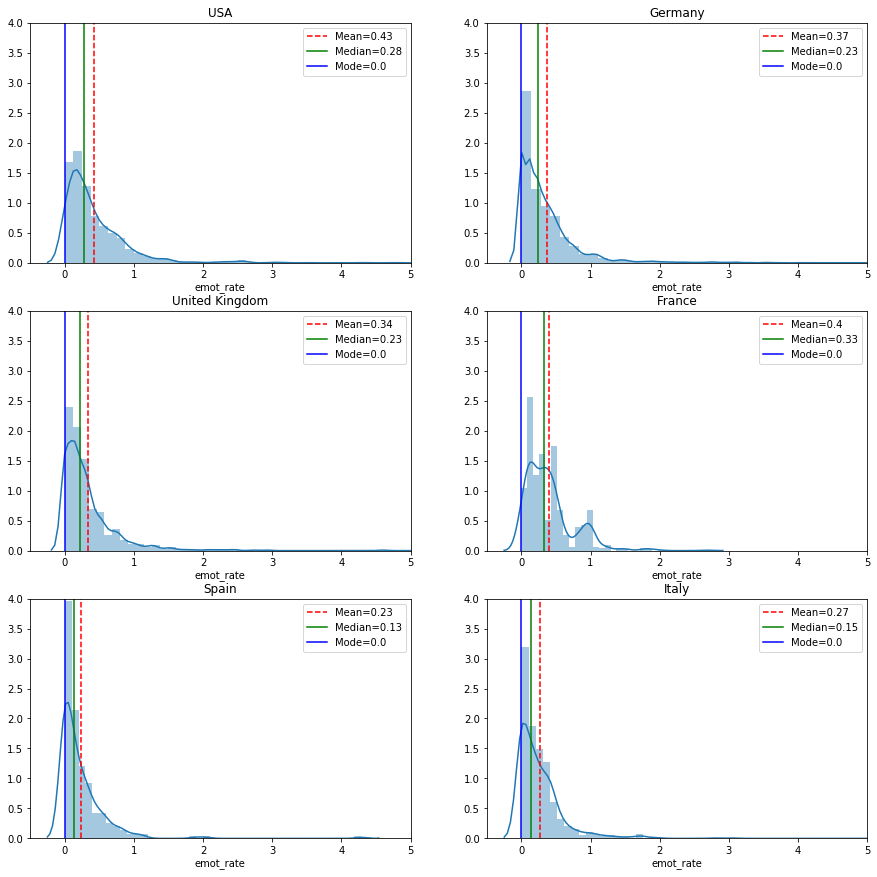

In [13]:
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(15,15))

#USA
g = sns.distplot(us_data[0].emot_rate, ax=axs[0, 0])
g.set_title('USA')
g.set(xlim=(-0.5,5))
g.set(ylim=(0,4))
mean_us = us_data[0].emot_rate.mean()
median_us = us_data[0].emot_rate.median()
mode_us = us_data[0].emot_rate.mode().get_values()[0]
axs[0, 0].axvline(mean_us, color='r', linestyle='--')
axs[0, 0].axvline(median_us, color='g', linestyle='-')
axs[0, 0].axvline(mode_us, color='b', linestyle='-')
g.legend({f'Mean={round(mean_us, 2)}':mean_us,f'Median={round(median_us, 2)}':median_us,f'Mode={round(mode_us, 2)}':mode_us})

#DE
g = sns.distplot(de_data[0].emot_rate, ax=axs[0, 1])
g.set_title('Germany')
g.set(xlim=(-0.5,5))
g.set(ylim=(0,4))
mean_de = de_data[0].emot_rate.mean()
median_de = de_data[0].emot_rate.median()
mode_de = de_data[0].emot_rate.mode().get_values()[0]
axs[0, 1].axvline(mean_de, color='r', linestyle='--')
axs[0, 1].axvline(median_de, color='g', linestyle='-')
axs[0, 1].axvline(mode_de, color='b', linestyle='-')
g.legend({f'Mean={round(mean_de, 2)}':mean_de,f'Median={round(median_de, 2)}':median_de,f'Mode={round(mode_de, 2)}':mode_de})

#UK
g = sns.distplot(uk_data[0].emot_rate, ax=axs[1, 0])
g.set_title('United Kingdom')
g.set(xlim=(-0.5,5))
g.set(ylim=(0,4))
mean_uk = uk_data[0].emot_rate.mean()
median_uk = uk_data[0].emot_rate.median()
mode_uk = uk_data[0].emot_rate.mode().get_values()[0]
axs[1, 0].axvline(mean_uk, color='r', linestyle='--')
axs[1, 0].axvline(median_uk, color='g', linestyle='-')
axs[1, 0].axvline(mode_uk, color='b', linestyle='-')
g.legend({f'Mean={round(mean_uk, 2)}':mean_uk,f'Median={round(median_uk, 2)}':median_uk,f'Mode={round(mode_uk, 2)}':mode_uk})

#FR
g = sns.distplot(fr_data[0].emot_rate, ax=axs[1, 1])
g.set_title('France')
g.set(xlim=(-0.5,5))
g.set(ylim=(0,4))
mean_fr = fr_data[0].emot_rate.mean()
median_fr = fr_data[0].emot_rate.median()
mode_fr = fr_data[0].emot_rate.mode().get_values()[0]
axs[1, 1].axvline(mean_fr, color='r', linestyle='--')
axs[1, 1].axvline(median_fr, color='g', linestyle='-')
axs[1, 1].axvline(mode_fr, color='b', linestyle='-')
g.legend({f'Mean={round(mean_fr, 2)}':mean_fr,f'Median={round(median_fr, 2)}':median_fr,f'Mode={round(mode_fr, 2)}':mode_fr})

#ES
g = sns.distplot(es_data[0].emot_rate, ax=axs[2, 0])
g.set_title('Spain')
g.set(xlim=(-0.5,5))
g.set(ylim=(0,4))
mean_es = es_data[0].emot_rate.mean()
median_es = es_data[0].emot_rate.median()
mode_es = es_data[0].emot_rate.mode().get_values()[0]
axs[2, 0].axvline(mean_es, color='r', linestyle='--')
axs[2, 0].axvline(median_es, color='g', linestyle='-')
axs[2, 0].axvline(mode_es, color='b', linestyle='-')
g.legend({f'Mean={round(mean_es, 2)}':mean_es,f'Median={round(median_es, 2)}':median_es,f'Mode={round(mode_es, 2)}':mode_es})

#IT
g = sns.distplot(it_data[0].emot_rate, ax=axs[2, 1])
g.set_title('Italy')
g.set(xlim=(-0.5,5))
g.set(ylim=(0,4))
mean_it = it_data[0].emot_rate.mean()
median_it = it_data[0].emot_rate.median()
mode_it = it_data[0].emot_rate.mode().get_values()[0]
axs[2, 1].axvline(mean_it, color='r', linestyle='--')
axs[2, 1].axvline(median_it, color='g', linestyle='-')
axs[2, 1].axvline(mode_it, color='b', linestyle='-')
g.legend({f'Mean={round(mean_it, 2)}':mean_it,f'Median={round(median_it, 2)}':median_it,f'Mode={round(mode_it, 2)}':mode_it})



In [14]:
# LDA model trained with term frequency (BOW)
all_lda_model_tf = load_pickled_file(pickled_data_path, 'all_lda_model_tf')

# LDA model trained with term frequency inverse document frequency (TF-IDF)
all_lda_model_tf_idf = load_pickled_file(pickled_data_path, 'all_lda_model_tf_idf')

#### 5.3.2) Visualization of trained models with pyLDAvis

In [21]:
pyLDAvis.enable_notebook()
lda_vis_tf = load_pickled_file(pickled_data_path, 'lda_vis_tf')
lda_vis_tf_idf = load_pickled_file(pickled_data_path, 'lda_vis_tf_idf')

In [22]:
lda_vis_tf

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.098993  0.160792       1        1  25.485643
1      0.133814  0.061949       2        1  21.697704
5     -0.223411  0.112938       3        1  17.968473
4     -0.151106 -0.095602       4        1  12.818116
3      0.018095 -0.154053       5        1  11.961846
2      0.123615 -0.086024       6        1  10.068217, topic_info=     Category        Freq        Term       Total  loglift  logprob
386   Default  254.000000     million  254.000000  30.0000  30.0000
1387  Default  413.000000     company  413.000000  29.0000  29.0000
587   Default  153.000000       index  153.000000  28.0000  28.0000
196   Default  166.000000        test  166.000000  27.0000  27.0000
231   Default  290.000000      market  290.000000  26.0000  26.0000
...       ...         ...         ...         ...      ...      ...
138    Topic6   22.078581   potential   54.899193   1.3849  -5.6555
433    Topic6   29.095631      global  162.702042   0.5745  -5.3795
1707   Topic6   23.307350  statements   72.245682   1.1645  -5.6013
246    Topic6   26.157984       virus  184.445999   0.3426  -5.4860
147    Topic6   23.080948     provide  156.822800   0.3797  -5.6111

[550 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
4657      6  0.948320      acid
2840      5  0.988046  adequacy
2552      2  0.054699    adjust
2552      3  0.109398    adjust
2552      4  0.738439    adjust
...     ...       ...       ...
217       2  0.059637      year
217       3  0.226620      year
217       4  0.457217      year
217       5  0.135177      year
217       6  0.015903      year

[1201 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 6, 5, 4, 3])

In [23]:
lda_vis_tf_idf

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.049629 -0.036576       1        1  48.639946
0     -0.211147  0.017439       2        1  18.852711
4      0.080143  0.188816       3        1  16.340319
1      0.143037 -0.083471       4        1   7.063182
3      0.054319 -0.038959       5        1   6.609774
5     -0.016723 -0.047249       6        1   2.494066, topic_info=     Category        Freq         Term       Total  loglift  logprob
386   Default  110.000000      million  110.000000  30.0000  30.0000
587   Default  104.000000        index  104.000000  29.0000  29.0000
712   Default   86.000000      billion   86.000000  28.0000  28.0000
3899  Default   51.000000        hooly   51.000000  27.0000  27.0000
1838  Default   73.000000      quarter   73.000000  26.0000  26.0000
...       ...         ...          ...         ...      ...      ...
2180   Topic6    4.038911     airlines   28.543842   1.7358  -5.9587
1862   Topic6    4.220886         wall   43.304939   1.3630  -5.9146
442    Topic6    4.279274     announce   64.365761   0.9805  -5.9009
479    Topic6    4.056130       friday   50.241909   1.1746  -5.9544
2047   Topic6    3.700444  containment   20.651968   1.9719  -6.0462

[423 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
2837      1  0.259503     absence
2837      5  0.692008     absence
1800      1  0.963972  accesswire
3331      4  0.778349  acconsenti
5918      5  0.929383  activision
...     ...       ...         ...
217       1  0.285296        year
217       2  0.105665        year
217       3  0.274729        year
217       4  0.253596        year
217       5  0.084532        year

[1034 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 5, 2, 4, 6])

## 2.) Results
#### Now all results from previous steps will be analyzed.

In [40]:
it_all_data = load_pickled_file(pickled_data_path, 'it_all_data')
de_all_data = load_pickled_file(pickled_data_path, 'de_all_data')
es_all_data = load_pickled_file(pickled_data_path, 'es_all_data')
fr_all_data = load_pickled_file(pickled_data_path, 'fr_all_data')
uk_all_data = load_pickled_file(pickled_data_path, 'uk_all_data')
us_all_data = load_pickled_file(pickled_data_path, 'us_all_data')

it_all_data_t = load_pickled_file(pickled_data_path, 'it_all_data_t')
de_all_data_t = load_pickled_file(pickled_data_path, 'de_all_data_t')
es_all_data_t = load_pickled_file(pickled_data_path, 'es_all_data_t')
fr_all_data_t = load_pickled_file(pickled_data_path, 'fr_all_data_t')
uk_all_data_t = load_pickled_file(pickled_data_path, 'uk_all_data_t')
us_all_data_t = load_pickled_file(pickled_data_path, 'us_all_data_t')

#### Italy

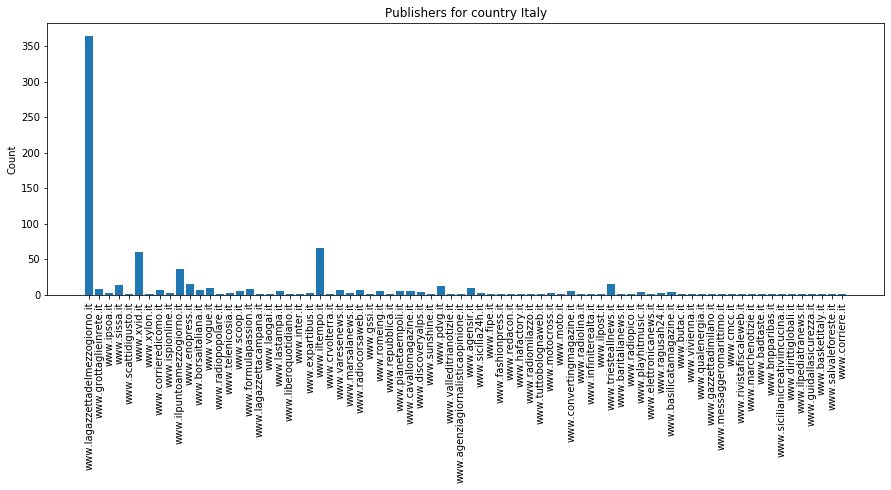

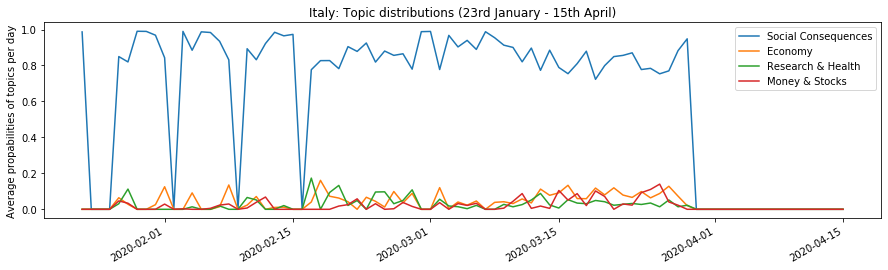

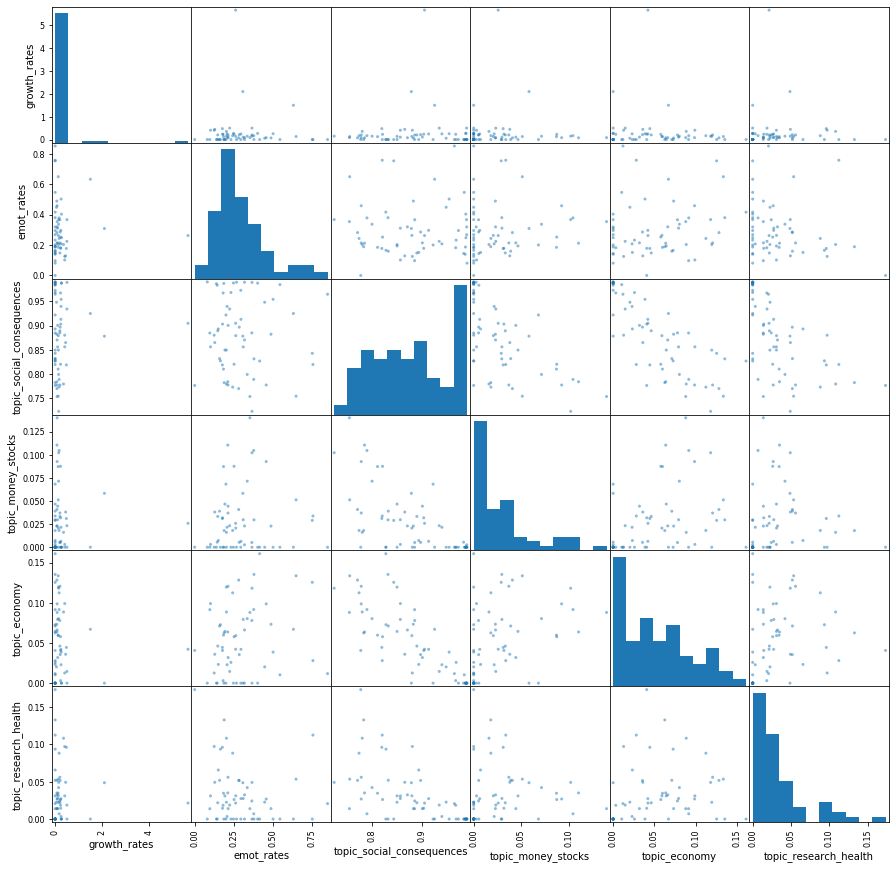

,growth_rates,emot_rates,topic_social_consequences,topic_money_stocks,topic_economy,topic_research_health
growth_rates,1,0.00493323,0.0559353,0.00888647,-0.0839938,-0.0234493
emot_rates,0.00493323,1,-0.0071867,0.0587567,0.177804,-0.21087
topic_social_consequences,0.0559353,-0.0071867,1,-0.637428,-0.78709,-0.596395
topic_money_stocks,0.00888647,0.0587567,-0.637428,1,0.341795,0.0350698
topic_economy,-0.0839938,0.177804,-0.78709,0.341795,1,0.178569
topic_research_health,-0.0234493,-0.21087,-0.596395,0.0350698,0.178569,1


In [33]:
visualize_topics(it_data[0], 'it', 'Italy')
plot_topics(it_all_data_t, 'Italy')
scatter_matrix(it_all_data, figsize=(15, 15))
plt.show()

corr_it = it_all_data.corr(method='spearman')
corr_it.style.background_gradient(cmap='coolwarm')

corr_it_p = it_all_data.corr(method='pearson')
corr_it_p.style.background_gradient(cmap='coolwarm')

#### Germany

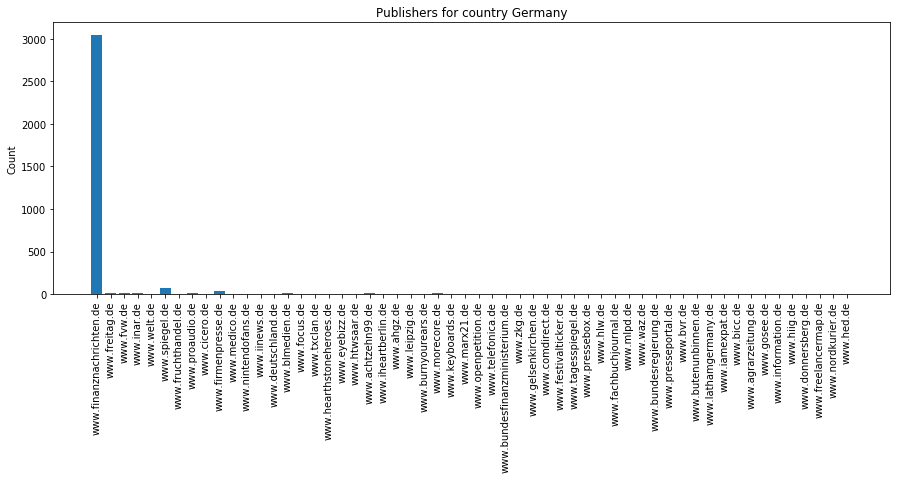

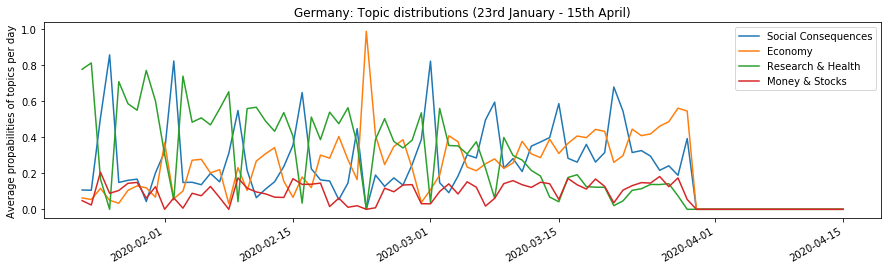

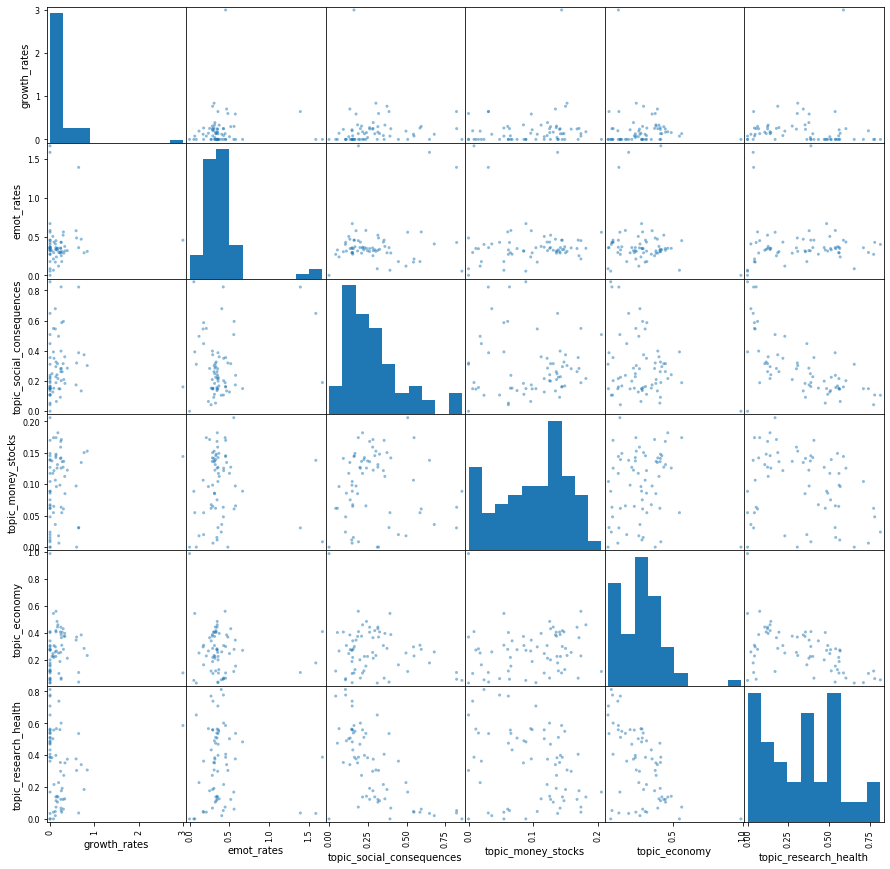

,growth_rates,emot_rates,topic_social_consequences,topic_money_stocks,topic_economy,topic_research_health
growth_rates,1,0.0570934,0.0316553,0.133733,-0.0637293,-0.0126179
emot_rates,0.0570934,1,0.184658,-0.0313557,-0.120818,-0.0577717
topic_social_consequences,0.0316553,0.184658,1,-0.0170255,-0.242125,-0.660667
topic_money_stocks,0.133733,-0.0313557,-0.0170255,1,0.0736297,-0.273091
topic_economy,-0.0637293,-0.120818,-0.242125,0.0736297,1,-0.532111
topic_research_health,-0.0126179,-0.0577717,-0.660667,-0.273091,-0.532111,1


In [34]:
visualize_topics(de_data[0], 'de', 'Germany')
plot_topics(de_all_data_t, 'Germany')
scatter_matrix(de_all_data, figsize=(15, 15))
plt.show()
corr_de = de_all_data.corr(method='spearman')
corr_de.style.background_gradient(cmap='coolwarm')

corr_de_p = de_all_data.corr(method='pearson')
corr_de_p.style.background_gradient(cmap='coolwarm')

#### Spain

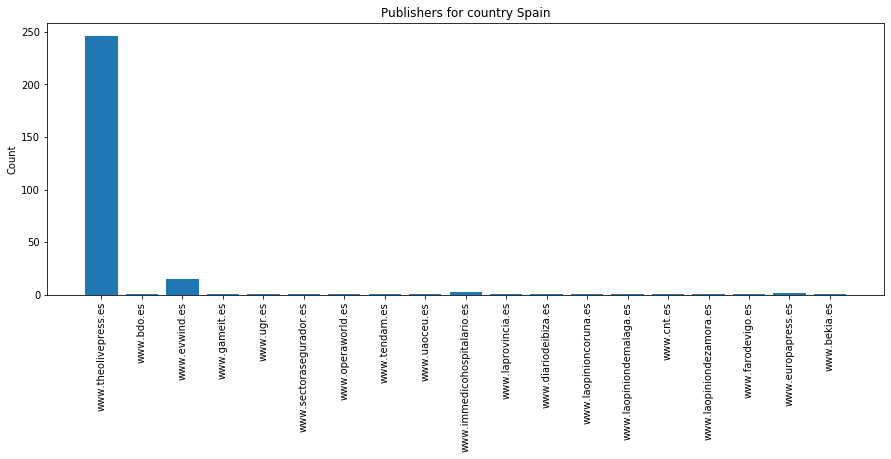

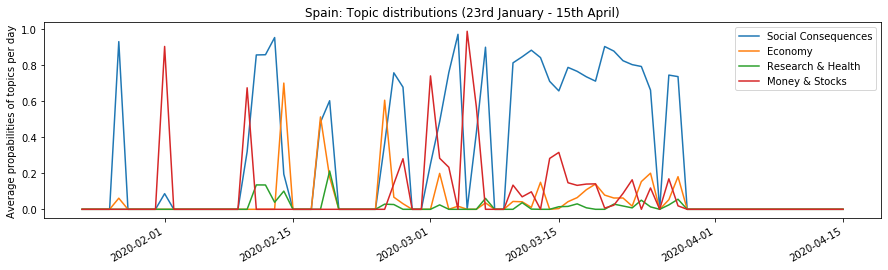

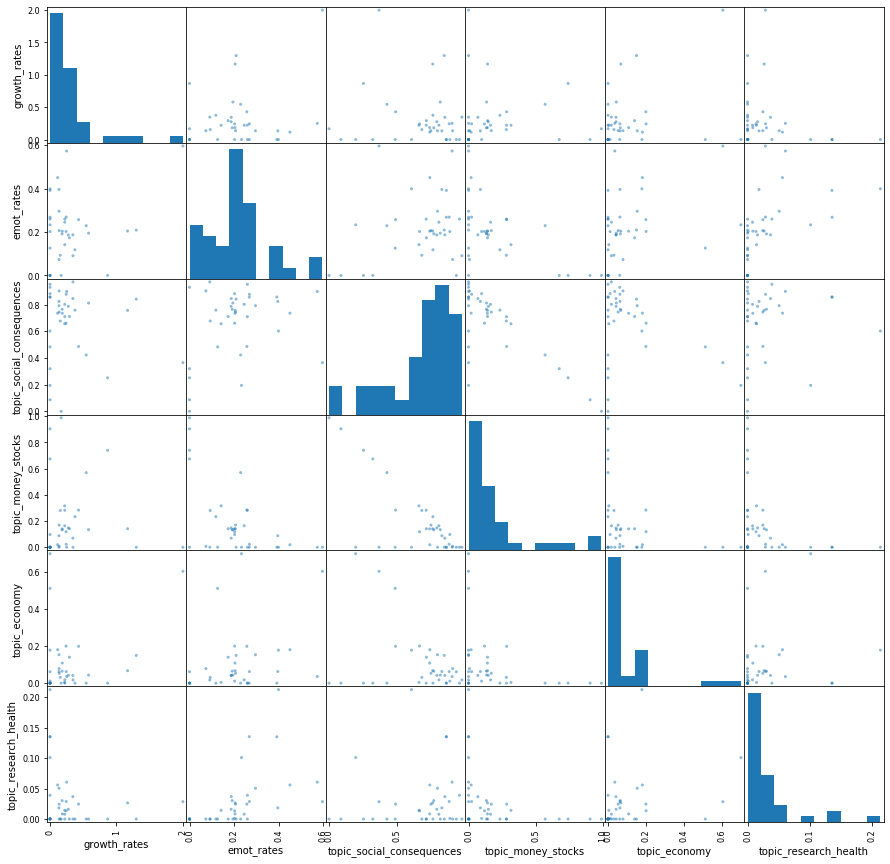

,growth_rates,emot_rates,topic_social_consequences,topic_money_stocks,topic_economy,topic_research_health
growth_rates,1,0.253,-0.118405,-0.0205998,0.276124,-0.218285
emot_rates,0.253,1,0.273234,-0.55322,0.321952,0.518392
topic_social_consequences,-0.118405,0.273234,1,-0.754885,-0.338677,0.0724499
topic_money_stocks,-0.0205998,-0.55322,-0.754885,1,-0.339614,-0.369886
topic_economy,0.276124,0.321952,-0.338677,-0.339614,1,0.195097
topic_research_health,-0.218285,0.518392,0.0724499,-0.369886,0.195097,1


In [35]:
visualize_topics(es_data[0], 'es', 'Spain')
plot_topics(es_all_data_t, 'Spain')
scatter_matrix(es_all_data, figsize=(15, 15))
plt.show()
corr_es = es_all_data.corr(method='spearman')
corr_es.style.background_gradient(cmap='coolwarm')

corr_es_p = es_all_data.corr(method='pearson')
corr_es_p.style.background_gradient(cmap='coolwarm')

#### France

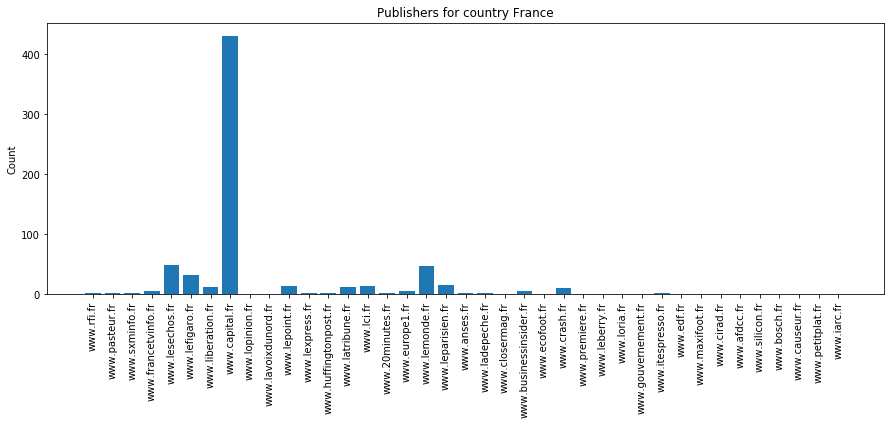

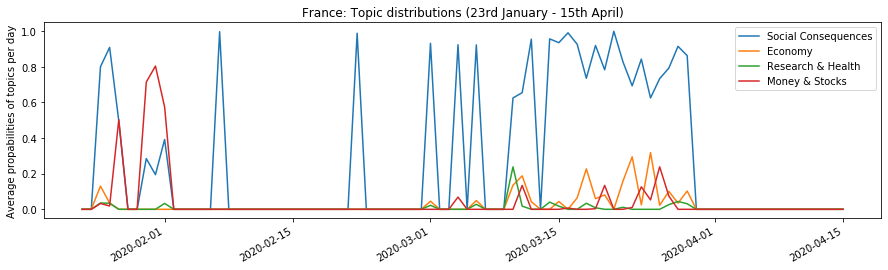

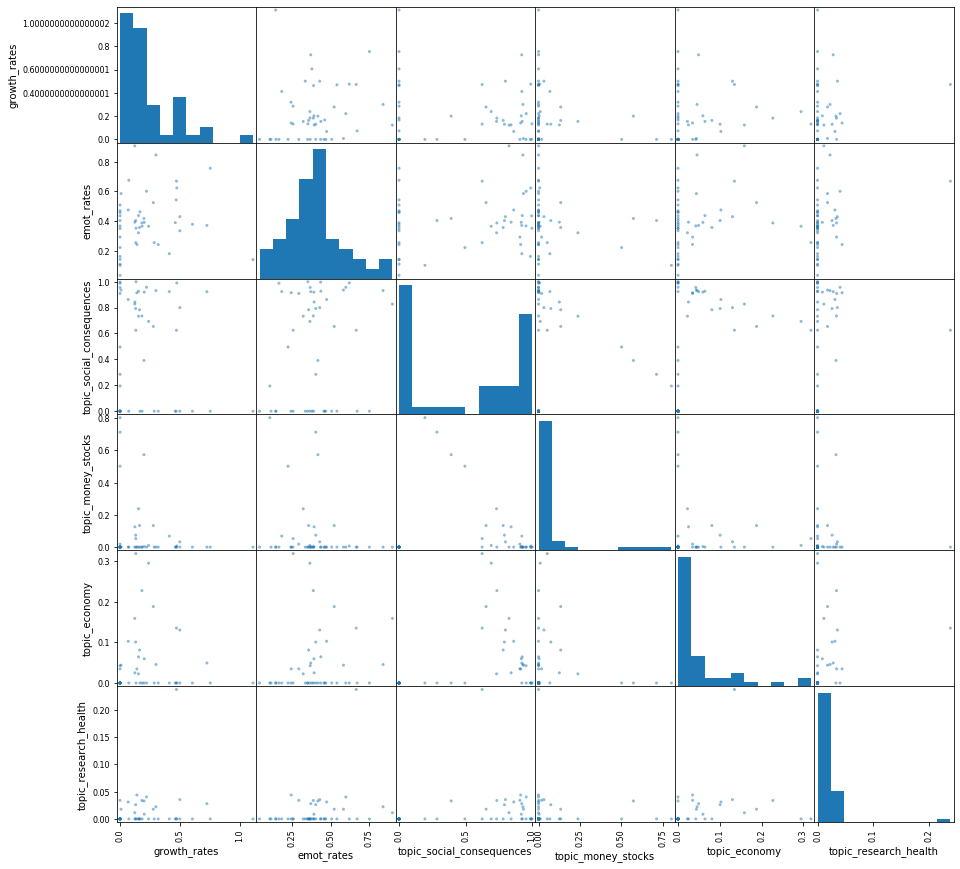

,growth_rates,emot_rates,topic_social_consequences,topic_money_stocks,topic_economy,topic_research_health
growth_rates,1,0.136755,-0.123417,-0.22143,0.000118821,0.153544
emot_rates,0.136755,1,0.193851,-0.211847,0.159827,0.27531
topic_social_consequences,-0.123417,0.193851,1,-0.0538425,0.369633,0.224039
topic_money_stocks,-0.22143,-0.211847,-0.0538425,1,-0.118446,-0.0646495
topic_economy,0.000118821,0.159827,0.369633,-0.118446,1,0.257798
topic_research_health,0.153544,0.27531,0.224039,-0.0646495,0.257798,1


In [36]:
visualize_topics(fr_data[0], 'fr', 'France')
plot_topics(fr_all_data_t, 'France')
scatter_matrix(fr_all_data, figsize=(15, 15))
plt.show()
corr_fr = fr_all_data.corr(method='spearman')
corr_fr.style.background_gradient(cmap='coolwarm')

corr_fr_p = fr_all_data.corr(method='pearson')
corr_fr_p.style.background_gradient(cmap='coolwarm')

#### US

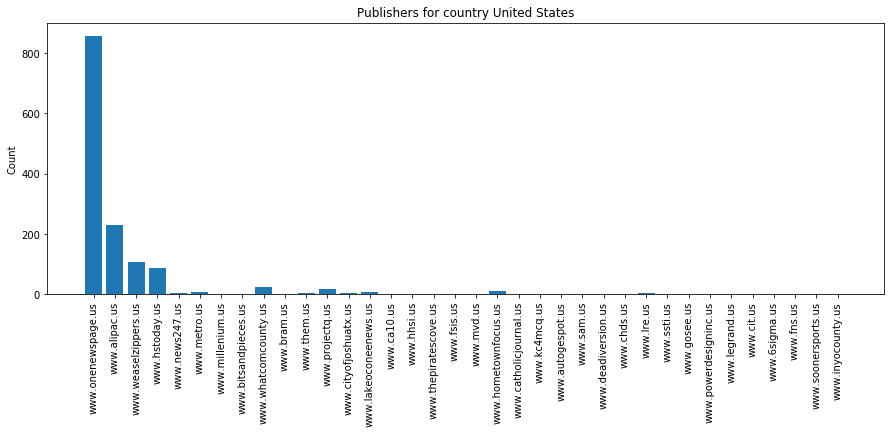

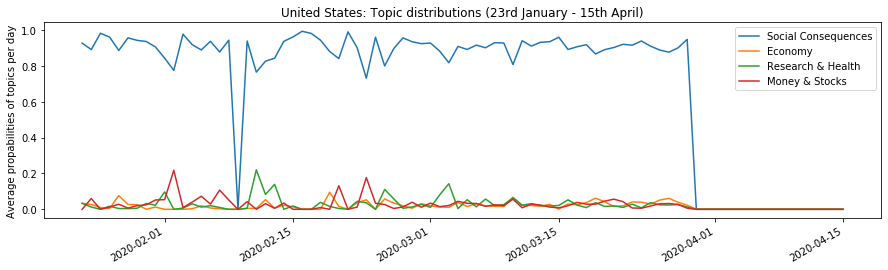

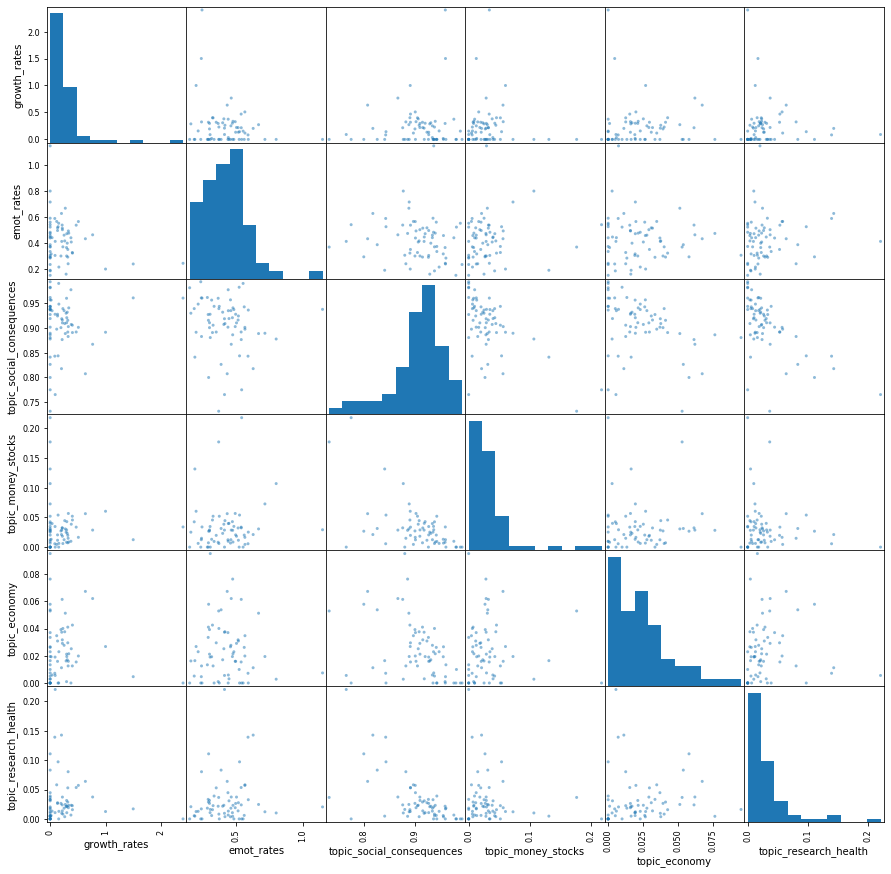

,growth_rates,emot_rates,topic_social_consequences,topic_money_stocks,topic_economy,topic_research_health
growth_rates,1,-0.223365,0.106986,-0.0505637,-0.0535854,-0.0658104
emot_rates,-0.223365,1,-0.121909,0.10744,-0.0510373,0.111676
topic_social_consequences,0.106986,-0.121909,1,-0.579155,-0.378207,-0.624331
topic_money_stocks,-0.0505637,0.10744,-0.579155,1,-0.0237237,-0.1524
topic_economy,-0.0535854,-0.0510373,-0.378207,-0.0237237,1,0.0221216
topic_research_health,-0.0658104,0.111676,-0.624331,-0.1524,0.0221216,1


In [37]:
visualize_topics(us_data[0], 'us', 'United States')
plot_topics(us_all_data_t, 'United States')
scatter_matrix(us_all_data, figsize=(15, 15))
plt.show()
corr_us = us_all_data.corr(method='spearman')
corr_us.style.background_gradient(cmap='coolwarm')

corr_us_p = us_all_data.corr(method='pearson')
corr_us_p.style.background_gradient(cmap='coolwarm')

#### UK

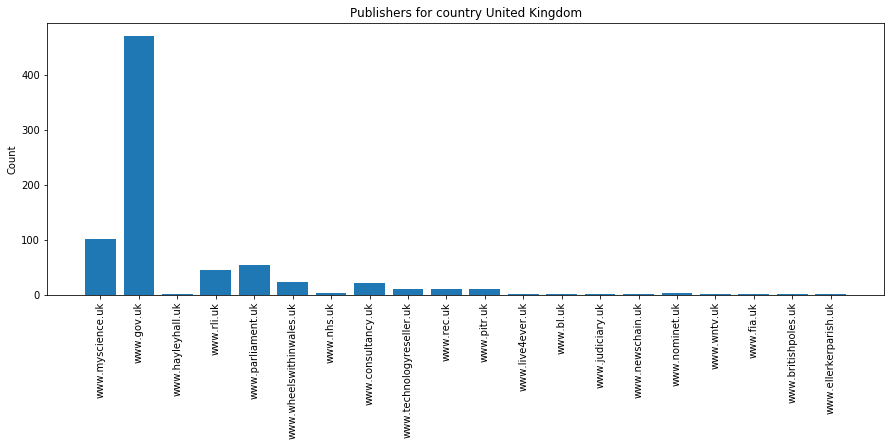

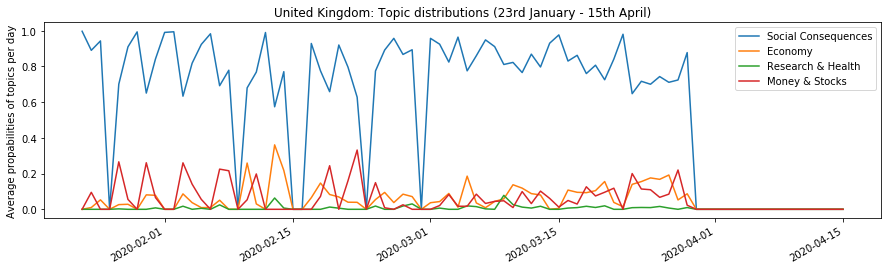

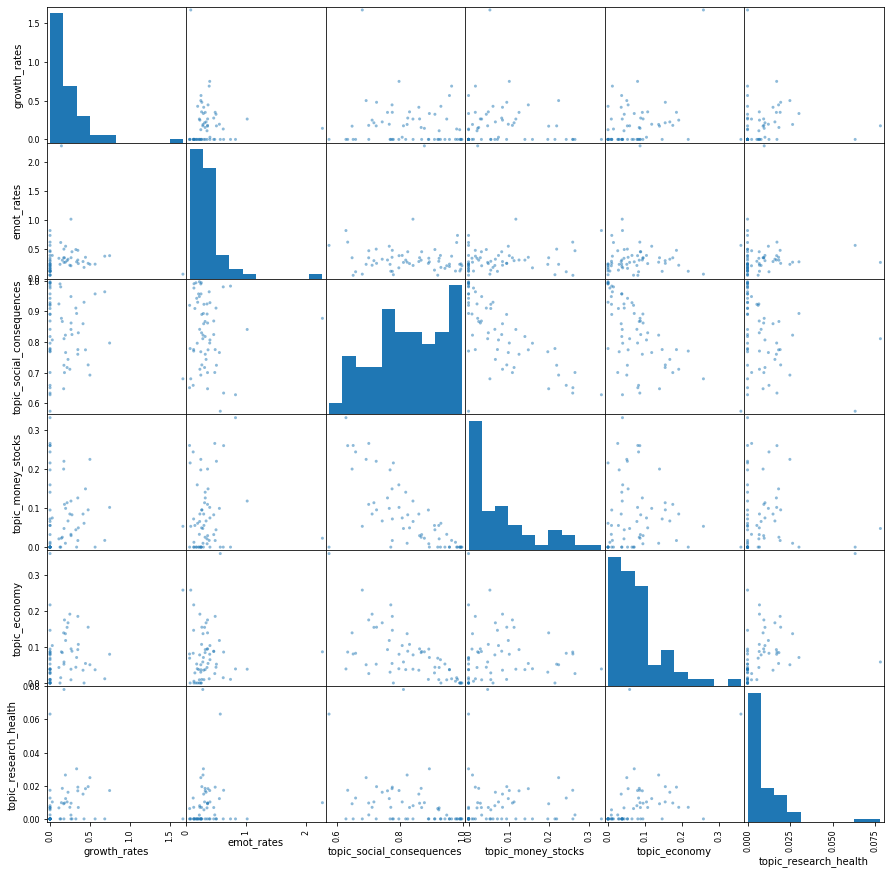

,growth_rates,emot_rates,topic_social_consequences,topic_money_stocks,topic_economy,topic_research_health
growth_rates,1,-0.0405176,-0.144235,-0.0583667,0.278711,0.0810381
emot_rates,-0.0405176,1,-0.0488164,0.034072,0.0339064,0.0623945
topic_social_consequences,-0.144235,-0.0488164,1,-0.722748,-0.648556,-0.368774
topic_money_stocks,-0.0583667,0.034072,-0.722748,1,-0.0456383,-0.0484943
topic_economy,0.278711,0.0339064,-0.648556,-0.0456383,1,0.450718
topic_research_health,0.0810381,0.0623945,-0.368774,-0.0484943,0.450718,1


In [38]:
visualize_topics(uk_data[0], 'uk', 'United Kingdom')
plot_topics(uk_all_data_t, 'United Kingdom')
scatter_matrix(uk_all_data, figsize=(15, 15))
plt.show()
corr_uk = uk_all_data.corr(method='spearman')
corr_uk.style.background_gradient(cmap='coolwarm')

corr_uk_p = uk_all_data.corr(method='pearson')
corr_uk_p.style.background_gradient(cmap='coolwarm')